In [9]:
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

class ModelHandler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model = self.load_model_and_tokenizer()

    def load_model_and_tokenizer(self):
        if self.model_name == 'facebook/bart-large-cnn':
            tokenizer = BartTokenizer.from_pretrained(self.model_name)
            model = BartForConditionalGeneration.from_pretrained(self.model_name)
        elif self.model_name == 't5-large':
            tokenizer = T5Tokenizer.from_pretrained(self.model_name)
            model = T5ForConditionalGeneration.from_pretrained(self.model_name)
        elif self.model_name == 'google/pegasus-xsum':
            tokenizer = PegasusTokenizer.from_pretrained(self.model_name)
            model = PegasusForConditionalGeneration.from_pretrained(self.model_name)
        else:
            raise ValueError("Unsupported model")
        return tokenizer, model

    def generate_summary(self, text):
        inputs = self.tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = self.model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

In [10]:
from rouge_score import rouge_scorer

class ROUGEScorer:
    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def score_summary(self, reference_summary, generated_summary):
        return self.scorer.score(reference_summary, generated_summary)


In [11]:
import pandas as pd

class DataProcessor:
    def __init__(self, texts, reference_summaries):
        self.data = [{"text": text, "reference_summary": ref} for text, ref in zip(texts, reference_summaries)]

    def process_data(self, models):
        results = []
        for item in self.data:
            text = item["text"]
            reference_summary = item["reference_summary"]
            for model_name in models:
                model_handler = ModelHandler(model_name)
                generated_summary = model_handler.generate_summary(text)
                rouge_scorer = ROUGEScorer()
                scores = rouge_scorer.score_summary(reference_summary, generated_summary)
                results.append({
                    'Model': model_name,
                    'Text Index': self.data.index(item),
                    'ROUGE-1': scores['rouge1'].fmeasure,
                    'ROUGE-2': scores['rouge2'].fmeasure,
                    'ROUGE-L': scores['rougeL'].fmeasure
                })
        return pd.DataFrame(results)


In [12]:
import matplotlib.pyplot as plt

class Plotter:
    @staticmethod
    def plot_rouge_scores(df_results):
        models_list = df_results['Model'].unique()
        rouge_1_scores = []
        rouge_2_scores = []
        rouge_l_scores = []

        for model in models_list:
            model_scores = df_results[df_results['Model'] == model]
            rouge_1_scores.append(model_scores['ROUGE-1'].mean())
            rouge_2_scores.append(model_scores['ROUGE-2'].mean())
            rouge_l_scores.append(model_scores['ROUGE-L'].mean())

        plt.figure(figsize=(12, 8))
        plt.plot(models_list, rouge_1_scores, marker='o', label='ROUGE-1', linestyle='--')
        plt.plot(models_list, rouge_2_scores, marker='o', label='ROUGE-2', linestyle='--')
        plt.plot(models_list, rouge_l_scores, marker='o', label='ROUGE-L', linestyle='--')

        plt.xlabel('Models')
        plt.ylabel('ROUGE Score')
        plt.title('Average ROUGE Scores for Different Summarization Models')
        plt.legend()
        plt.grid(True)
        plt.show()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings

ROUGE Scores Matrix:
                      Model  Text Index   ROUGE-1   ROUGE-2   ROUGE-L
0   facebook/bart-large-cnn           0  0.567568  0.194444  0.378378
1                  t5-large           0  0.560000  0.191781  0.373333
2       google/pegasus-xsum           0  0.494118  0.168675  0.329412
3   facebook/bart-large-cnn           1  0.202020  0.082474  0.121212
4                  t5-large           1  0.326923  0.078431  0.173077
5       google/pegasus-xsum           1  0.080000  0.000000  0.060000
6   facebook/bart-large-cnn           2  0.169231  0.000000  0.123077
7                  t5-large           2  0.166667  0.030769  0.151515
8       google/pegasus-xsum           2  0.160714  0.018182  0.142857
9   facebook/bart-large-cnn           3  0.327586  0.192982  0.293103
10                 t5-large           3  0.267717  0.144000  0.236220
11      google/pegasus-xsum           3  0.170213  0.043478  0.085106
12  facebook/bart-large-cnn           4  0.363636  0.073620  0.157576

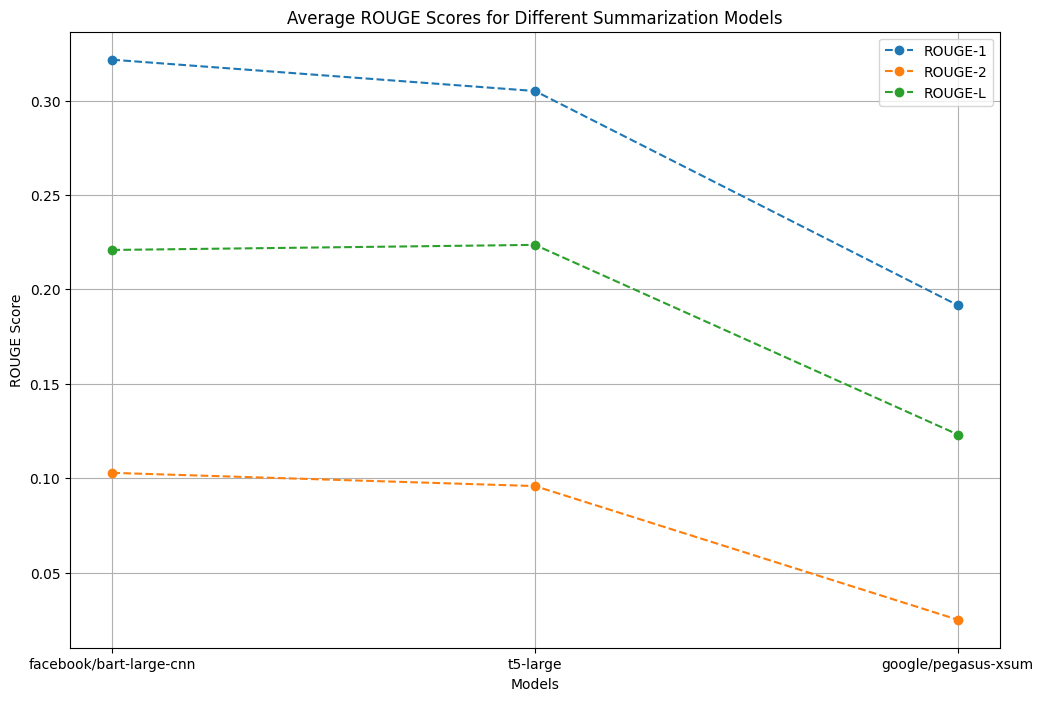

In [15]:
def main():
    # Define texts and their reference summaries
    texts = [
        "Stephen Hsu is a professor of physics at Michigan State University, and Founder of a number of tech startups such as Genomic Prediction, Othram, and Superfocus. In this interview we discuss genetic engineering, the future of AI, and mitigating catastrophic risks. This interview has been edited for organization, clarity, and concision. The full audio will be published shortly.",
        "What are you most worried about when it comes to genetic engineering? And what worries do you think are the most overblown? SH:I think among specialists, the most overblown concern is pleiotropy. The modal geneticist probably tends to overestimate the amount of pleiotropy in the genome. Often they don't really have good intuitions for high dimensional spaces, or they were told in a textbook that pleiotropy is significant. But all of our empirical tests show that pleiotropy is not that strong, so you can have big gains which are pretty safe, or you can boost one trait without necessarily screwing up something else. The underlying deep structure of our genetic architecture is different from what most people intuit from their biology education, mainly because genetic traits occupy a much higher dimensional space than most people are used to thinking about.",
        "I think a very real concern is that we could go through an era of very strong inequality like we've never seen before. When you have selected or engineered humans that are very different from the wild type, and 90% of the world population is still wild type, you’re going to have a breakaway elite. There was a period of time where aristocrats in England were quite a bit taller than normal people just because they had better nutrition growing up, while the lower classes were nutritionally deprived. Imagine a guy in his evening jacket with a cane who’s literally a head taller than his carriage driver. That guy could have attended Oxford and been educated on Euclid, or Gauss, while his shoe shiner was illiterate.  People often forget that this happened, but that was the norm in most countries just 100 or 200 years ago. One can imagine a future where the edited/selected people are tall, beautiful, athletic, and live to be 200 years old—at dinner they’re discussing convex optimization of objective functions in complexified tensor spaces, while the server has no hope of ever understanding their discussion no matter how hard they study. In our recent past inequality has been mitigated by nutrition and mass education, but it would become far more entrenched if the difference was purely from genetic enhancements. We want to avoid a world where such inequalities exist, especially when the cause is genetic modification or genetic selection.",
        "What does a good long-term future look like, in terms of a healthy way that humanity could be reconciled with genetic technology? SH: In the long run, we could improve humanity. People in the future could on average be smarter, much longer lived, nicer, more cooperative, lower rates of mental illness. I think this will be within our grasp technologically in the near future. I don’t know if society will organize itself to achieve these things. Having worked in this field for 10 or 12 years, I think it’s been established in published papers that we can predict complex traits through DNA. We built a company which can genotype embryos and select embryos based on this information, so I have no doubt what I just described is a possible future outcome that humanity could achieve. Whether it will get there, I don’t know.",
        "You’ve described something akin to “let a thousand flowers bloom” when it comes to the traits that people might select for.  You’ve mentioned that an academic might choose the smartest kid, a beautiful person the most beautiful, and a strong person the strongest. But doesn't this seem to run up against the fact that if all these traits are independent wouldn’t everyone just choose to move the IQ slider up to the maximum? And then selecting aesthetic qualities, like eye color or height, would become a Keynesian beauty contest of choosing what's most popular? So maybe a thousand flowers won’t bloom.",
        "SH:The examples I've given in the past are all based on real conversations I have had with trophy wives of billionaires and, you know, hedge fund masters of the universe. If you're the top hedge fund guy in the world, you often know you are not the smartest guy in the world. You employ people that are smarter than you, or you might talk with scientists who are smarter than you. And yet somehow you are super successful and you have the private jet and you fly in the scientists to talk with you. So what they consider important and valuable might be a little different than what Joe academic PhD thinks. And the same thing with their trophy wife. Who's having the greatest lives? Is it the brainy guys in the library? I'm not sure. Did Kobe or Michael Jordan have a great life? Are they having better lives than like Noam Chomsky? So there really is a diversity of preferences.",
        "If there are no downsides to moving the slider up, won’t everyone maximize all plausibly beneficial traits? If pleiotropy really is low, this seems to be a possibility.",
        "SH: So there could be downsides, like imagine you become so smart, that you can appreciate the beauty of category theory, and quantum gravity. And you want to spend the rest of your life trying to think about those things and develop those things, which are the most beautiful creations of the human mind, at the expense of having lots of kids and a trillion dollar company. Academics might think it’s one of the best things to be smart, but I’m not sure that it is.",
        "But let me just explain why these are going to be constrained choices for quite a while if you’re doing embryo selection. Let’s suppose you’re a billionaire with 300 frozen eggs from a donor, and you have surrogate mothers who will carry them to term. So you've outsourced the whole thing. But you still only have 300 eggs, and you want to pick the best one. And the one that's the smartest is also not necessarily the one that has the best facial morphology or the best team leader personality or, you know, the broadest shoulders. So these things, if you have a finite number of embryos to choose from, you're going to be trading things off. Even if you have perfect predictors, you're going to be trading things off. And then you could say, oh, in the next phase, we won't do that. We'll have CRISPR and we’ll edit in whatever direction we want. But there's probably going to always be a limit to the number of edits you're willing to make because there's some off target rate. So you still probably will have a budget of edits that you can make. And you'll be a little leery of going way beyond that budget of edits. And then you have to allocate those edits toward some quasi-independent different traits. So I don't want to predict what happens.",
        "I think your point about constraints is well put, and a big piece of the puzzle. I know Gwern has also said that CRISPR style gene editing is probably not as revolutionary as was first anticipated.",
        "SH: The reason for that is because we don't know exactly which edits to make yet. There are two problems holding CRISPR back. One is the off target thing. Like how many edits can you really safely do without accidentally doing some edits you did not want to do? That is a technological problem that the molecular biology jockeys are trying to fix right now. The second one, which is a data problem, which is more in my field is, which edits would you actually want to make? And even though you have a predictor for height, do you know what the causality is for each of those changes that you are going to make? The predictor may know that there is a SNP in this region of the genome, which correlates with height and it allows me to predict height. But we do not necessarily know exactly what edit we should make because in the neighborhood of that SNP are a bunch of other correlated SNPs and the true causal one might be one or two SNPs over. And so that problem is still unsolved in computational genomics—we do not actually know how to make the edits, or even which exact edits, to make. It’s likely to take a long time to solve because we need a lot of data.",
        "To clarify: With embryo selection you can rely on correlations between genotype and phenotype, while with CRISPR you have to go a lot deeper to actually find the causal connections?",
        "SH: That's exactly right—prediction only requires correlation. Manipulation requires a causal map. And so even for these really simple disorders it can require a large number of edits. For instance, the widely understood and known genetic variants which lead to elevated breast cancer risk tend to be in the BRCA1 and BRCA2 genes. And those are typically single alleles, with Mendelian properties. But most women in the population who get breast cancer do not have these BRCA mutations. Only one in a thousand women has the BRCA mutations. Most women who have a family history of breast cancer and have high polygenic breast cancer risk are not carriers of any BRCA variants. The BRCA genes are just the tip of the iceberg, and we discovered that these rare mutations have huge effects. But once we started processing the data, we realized that most people who are at high risk for breast cancer got an unlucky throw of the dice in a thousand different locations in the genome. Disease susceptibility is typically quite polygenic, and it’s a point that hasn’t fully been understood in biomedical science.",
        "So is that the reason why CRISPR hasn't had the radical impact that some have been worried about? There doesn’t seem to be any rogue gene drives decimating insect populations or crazed terrorists releasing engineered pathogens yet.",
        "SH: There are many super well-funded startups developing CRISPR related therapies. Imagine a situation where there is a Mendelian variant. It's a single place that you need to edit and we understand it because it is simple and has a big effect. Let’s say that people with this weird variant have 10 times the risk of heart disease. You could apply CRISPR treatments to an embryo fairly easily because there's only around 100 cells you need to edit. Or you could apply it to an adult who has a heart which weighs like a kilogram—there’s a lot of cells in there and you need to edit all of them. How are you going to inject the CRISPR viral agent into every cell in that heart? An eye problem like macular degeneration would be a little easier since it’s not that big. I would conservatively estimate that there are billions of dollars invested in companies racing toward these kinds of solutions, but it is not easy. And these are just for finite, high impact mutations where the genetic architecture is quite simple: A or B, and if you have A,I will edit it to B for you. But even then, you may have to edit a billion cells or something. So it's non-trivial.",
        ]
    reference_summaries = [
        "Stephen Hsu, a Michigan State University physics professor and tech startup founder, discusses genetic engineering, AI, and risk mitigation in an upcoming interview. The interview, which has been edited for clarity, will be available in full soon.",
        "Stephen Hsu believes that fears about pleiotropy in genetic engineering are overstated. He argues that specialists often overestimate pleiotropy's impact because they lack an intuitive understanding of high-dimensional genetic spaces. Empirical evidence shows that pleiotropy is less significant than commonly thought, allowing for substantial improvements in one trait without major negative effects on others. Genetic architecture is more complex than traditional biology education suggests.",
        "Stephen Hsu expresses concern about the potential for extreme inequality resulting from genetic engineering. He compares it to historical disparities, such as those between aristocrats and the lower classes in 19th-century England. Hsu warns that if genetically engineered individuals become significantly superior in traits like intelligence and longevity, while the majority of the population remains unmodified, it could lead to a new class of elite with vastly different capabilities and experiences. He emphasizes the need to address and prevent such inequalities driven by genetic modifications.",
        "Stephen Hsu envisions a positive long-term future where genetic technology enhances human traits, leading to smarter, healthier, and more cooperative individuals with lower rates of mental illness. He believes that while technological advancements make this possible, it's uncertain whether society will organize itself to achieve these outcomes. He notes that current capabilities, such as predicting complex traits through DNA and embryo selection, support the feasibility of this vision.",
        "The idea of 'letting a thousand flowers bloom' in trait selection implies diverse preferences for traits like intelligence, beauty, or strength. However, if traits are independent, people might prioritize maximizing IQ across the board. This could lead to a uniform focus on intelligence rather than a variety of traits, making aesthetic qualities more about popularity and less diverse than initially envisioned. Thus, the concept of diverse trait selection might be challenged by a tendency to favor the most valued trait.",
        "Stephen Hsu argues that preferences for traits are subjective and varied. Drawing from conversations with wealthy individuals, he notes that success and value are not solely determined by intelligence. People in high positions, like top hedge fund managers, often recognize their own limitations and value diverse qualities. He questions whether intellectual achievement always correlates with a better life compared to those excelling in other areas, like sports or different fields, highlighting a wide range of personal preferences.",
        "If there are no negative consequences, and pleiotropy is minimal, it's conceivable that everyone would aim to enhance all beneficial traits to their maximum potential.",
        "Stephen Hsu suggests that extreme intelligence could have drawbacks. For instance, someone might become so focused on intellectual pursuits like category theory or quantum gravity that they neglect other aspects of life, such as having children or running a successful business. He questions whether extreme intelligence is inherently advantageous, as it might lead to a narrow focus on specific interests at the expense of broader life experiences.",
        "Stephen Hsu explains that embryo selection will be limited by practical constraints. Even with a large number of embryos, such as 300, selecting the best one involves trade-offs between different traits like intelligence, appearance, and personality. Additionally, future CRISPR technology will face limitations due to off-target effects and the need to allocate a limited number of genetic edits across various traits. He emphasizes the inherent constraints in both current and future genetic selection methods, making precise predictions challenging.",
        "Stephen Hsu acknowledges the validity of concerns about constraints in genetic selection and agrees with Gwern's view that CRISPR gene editing might not be as revolutionary as initially expected.",
        "Stephen Hsu outlines two major challenges facing CRISPR technology: off-target effects and the complexity of identifying precise genetic edits. The first issue involves ensuring that edits do not unintentionally affect other parts of the genome. The second problem is understanding the causal relationships between genetic variants and traits, as predictors may identify correlations but not the exact causal edits needed. Hsu emphasizes that solving these issues will require significant time and data.",
        "Yes, with embryo selection, you use correlations between genotype and phenotype to make decisions. In contrast, CRISPR requires understanding the causal connections between genes and traits, which involves more detailed and complex analysis to identify the precise genetic edits needed.",
        "Stephen Hsu explains that while predicting traits only requires understanding correlations, manipulating genes requires a detailed causal map. He uses breast cancer risk as an example, noting that while BRCA1 and BRCA2 mutations are well-known and have a significant impact, most women with high breast cancer risk do not carry these mutations. Instead, high risk often arises from a combination of many genetic factors spread across the genome, highlighting the polygenic nature of disease susceptibility.",
        "Stephen Hsu suggests that CRISPR’s limited radical impact so far, such as the absence of rogue gene drives or engineered pathogens, is due to ongoing challenges in the technology and its application. The difficulties in achieving precise genetic edits and managing off-target effects may have contributed to this restrained progress.",
        "Stephen Hsu explains that while CRISPR holds promise, its application faces significant challenges. For Mendelian disorders with a single genetic variant, editing embryos is relatively straightforward. However, for complex conditions affecting many cells, like heart disease, delivering CRISPR to every cell in the body is much more difficult. Despite substantial investment in CRISPR research, achieving these therapeutic goals remains complex due to the technical difficulties of precise and widespread genetic editing.",
    ]

    # Define models to evaluate
    models = ['facebook/bart-large-cnn', 't5-large', 'google/pegasus-xsum']

    # Process data and compute ROUGE scores
    data_processor = DataProcessor(texts, reference_summaries)
    df_results = data_processor.process_data(models)

    # Print the results
    print("ROUGE Scores Matrix:")
    print(df_results)

    # Plot the results
    Plotter.plot_rouge_scores(df_results)

if __name__ == "__main__":
    main()
